# Exploratory Data Analysis

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
# custom dtypes for data
from scripts.utils_data import DTYPES_SIMPLE
from scripts.utils_visualizations import show_distribution

## Constants 

In [3]:
PATH_SIMPLE = '../data/processed/electronics_simple.csv'

## Load Data

In [4]:
df = pd.read_csv(PATH_SIMPLE,
                 low_memory=True,
                 dtype=DTYPES_SIMPLE)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6739590 entries, 0 to 6739589
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   overall      int16 
 1   vote         int64 
 2   reviewMonth  int16 
 3   reviewText   object
 4   reviewYear   int16 
dtypes: int16(3), int64(1), object(1)
memory usage: 141.4+ MB


In [6]:
df.head()

,overall,vote,reviewMonth,reviewText,reviewYear
0,5,67,9,This is the best novel I have read in 2 or 3 y...,1999
1,3,5,10,"Pages and pages of introspection, in the style...",2013
2,5,4,9,This is the kind of novel to read when you hav...,2008
3,5,13,9,What gorgeous language! What an incredible wri...,2000
4,3,8,2,I was taken in by reviews that compared this b...,2000


## Visualizations

In [7]:
# Calculate distribution
rating_cnt = df.overall.value_counts()
vote_cnt = df.vote.value_counts()
month_cnt = df.reviewMonth.value_counts()
year_cnt = df.reviewYear.value_counts()

In [8]:
df['textLength'] = df.reviewText.str.len()

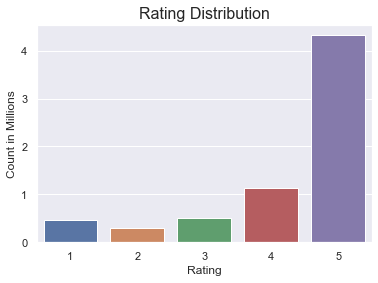

In [9]:
show_distribution(rating_cnt, 'Rating Distribution', 'Rating', normalize=1_000_000, norm_name='Millions')

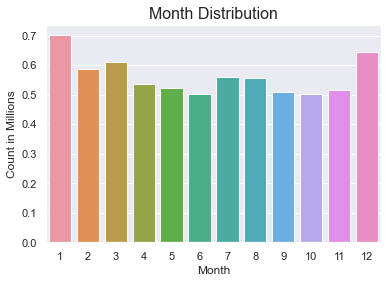

In [10]:
show_distribution(month_cnt, 'Month Distribution', 'Month', normalize=1_000_000, norm_name='Millions')

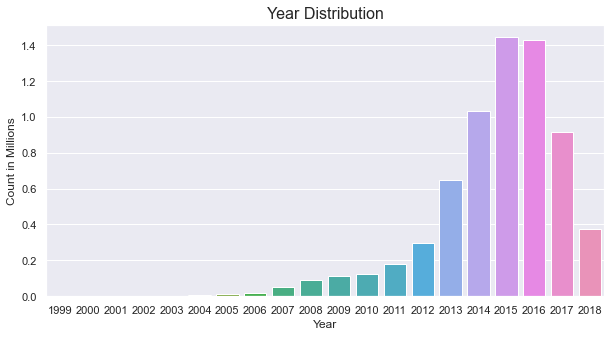

In [11]:
show_distribution(year_cnt, 'Year Distribution', 'Year',
                  normalize=1_000_000, norm_name='Millions',
                  figsize=(10,5))

In [21]:
mean_length = df.textLength.mean()
std_length = df.textLength.std()
lower_length, upper_length = 0, round(mean_length + 3 * std_length)

print('TEXT LENGTH')
print('Mean', mean_length)
print('Std', std_length)
print('Range without outliers:', lower_length, '-', upper_length)

TEXT LENGTH
Mean 354.2196773575027
Std 649.0171788348541
Range without outliers: 0 - 2301


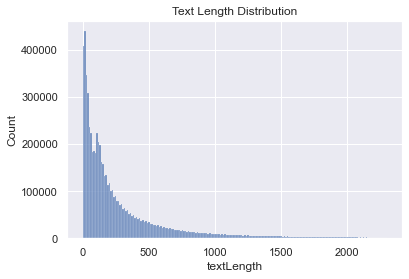

In [22]:
sns.histplot(x=df.textLength, bins=200, binrange=(lower_length, upper_length))
plt.title("Text Length Distribution")
plt.show()

In [25]:
mean_vote = df.vote.mean()
std_vote = df.vote.std()
lower_vote, upper_vote = 1, round(mean_vote + 3 * std_vote)

print('HELPFUL VOTES')
print('Mean', mean_vote)
print('Std', std_vote)
print('Range without outliers:', lower_vote, '-', upper_vote)

HELPFUL VOTES
Mean 1.5717807759819218
Std 19.983559398920605
Range without outliers: 1 - 62


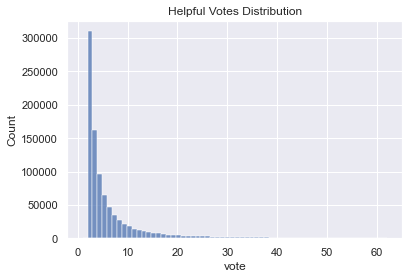

In [26]:
sns.histplot(x=df.vote, bins=62, binrange=(lower_vote, upper_vote), palette='viridis')
plt.title("Helpful Votes Distribution")
plt.show()

In [28]:
all_votes = df.vote.shape[0]
yes_vote = (df.vote > 0).sum()
no_vote = all_votes - yes_vote

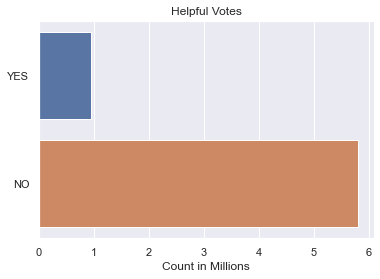

In [31]:
sns.barplot(y=['YES', 'NO'], x=np.array([yes_vote, no_vote])/ 1_000_000)
plt.title('Helpful Votes')
plt.xlabel('Count in Millions')
plt.show()